In [60]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import os
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from pyemma.coordinates import tica
import warnings
import pandas as pd
from math import floor, log10
warnings.filterwarnings("ignore")
plt.style.use(['science','no-latex'])
name_dict = {'pre': 'QM (1k) Training',
             'post_cycle1': 'QM (1k) + 1 Cycle Observable Training',
             'post_cycle2': 'QM (1k) + 2 Cycles Observable Training',
             'post_cycle3': 'QM (1k) + 3 Cycles Observable Training',
             'post': 'QM (1k) + All Cycles Observable Training',
             '10k': 'QM (10k) Training',
             '50k': 'QM (50k) Training'}
import matplotlib.pylab as pylab
params = {'figure.dpi': 600,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'small',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

def round3(x):
    """ Round a number to 3 significant digits. """
    try:
        return round(x, 2 - int(floor(log10(abs(x)))) - 1) if x != 0 else 0
    except:
        return x
            
def plot_stability_distribution(molecule, exp_dir, names):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in names:
        stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
        plt.hist(stab, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"Stable Simulation Time (ps)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    
def plot_observable_mae_distribution(molecule, exp_dir, names, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in names:
        maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
        plt.hist(maes, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"{observable.upper()} MAE", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    

def plot_observable_mae_difference_distribution(molecule, exp_dir, names, observable = 'rdf'):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    for name in names:
        if "pre" not in name and 'k' not in name:
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            plt.hist(100*(maes - pre_maes)/pre_maes, bins = 50, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule[0].upper() + molecule[1:], fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"Change in {observable.upper()} MAE after Observable Training (%)", fontsize=8)
    plt.ylabel("Frequency", fontsize=14)
    
def plot_observable(molecule, exp_dir, names, observable = 'rdf', criterion = 'stab', diff = False):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    pre_maes = np.load(os.path.join(inference_dir, "pre", f'final_{observable}_maes.npy'))
    pre_stab = np.load(os.path.join(inference_dir, "pre", 'replicas_stable_time.npy'))
    pre_obs = np.load(os.path.join(inference_dir, "pre", f'final_{observable}s.npy'))
    gt_obs = np.load(os.path.join(inference_dir, "pre", f'gt_{observable}.npy'))
    if observable == 'rdf':
        gt_obs /=2
        x_axis = np.linspace(0, 10, 500)
    elif observable == 'adf':
        x_axis = np.linspace(0, np.pi, 180)
    elif observable == 'vacf':
        x_axis = np.linspace(0, 50, 100)
    
    for name in names:
        if "pre" not in name:
            maes = np.load(os.path.join(inference_dir, name, f'final_{observable}_maes.npy'))
            stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
            obs = np.load(os.path.join(inference_dir, name, f'final_{observable}s.npy'))
            percent_change_mae = 100*(maes - pre_maes)/pre_maes
            mean_percent_change_mae = percent_change_mae.mean()
            mean_mae_replica = np.argmin(np.abs(percent_change_mae - mean_percent_change_mae))
            mean_stab_imp_replica = np.argmin(np.abs((stab-pre_stab) - np.mean(stab - pre_stab)))
            replica = mean_stab_imp_replica if criterion == "stab" else mean_mae_replica
            if diff:
                plt.plot(x_axis, obs[replica] - gt_obs, label=name_dict[name])
            else:
                plt.plot(x_axis, obs[replica], label=name_dict[name])
    if diff:
        plt.plot(x_axis, pre_obs[replica] - gt_obs, label=name_dict["pre"])
    else:
        plt.plot(x_axis, pre_obs[replica], label=name_dict["pre"])
    if not diff:
        plt.plot(x_axis, gt_obs, label="Ground Truth")
    if observable == 'rdf':
        xlabel = "r (Angstroms)"
        ylabel = "h(r)"
        title  = "Distribution of Interatomic Distances"
    elif observable == 'adf':
        xlabel = "Angle (radians)"
        ylabel = "ADF"
        title  = "Angular Distribution Function"
    elif observable == 'vacf':
        xlabel = "Time lag (fs)"
        ylabel = "Normalized VACF"
        title  = "Velocity Autocorrelation Function"
    
    if diff:
        title +=" - Diff"
        ylabel +=" - Diff"
    
    plt.title(molecule[0].upper() + molecule[1:] + ": " + title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = 'upper right')
    
    
def collect_metrics(molecule, exp_dir, names):
    inference_dir = os.path.join(exp_dir, 'inference')
    mean_rdf_maes = []
    mean_adf_maes = []
    mean_vacf_maes = []
    std_rdf_maes = []
    std_adf_maes = []
    std_vacf_maes = []
    mean_stability = []
    std_stability = []
    mean_force_mae = []
    for name in names:
        metrics = json.load(open(os.path.join(inference_dir, name, 'final_metrics.json')))
        mean_rdf_maes.append(round3(metrics['Mean RDF MAE']))
        mean_adf_maes.append(round3(metrics['Mean ADF MAE']))
        mean_vacf_maes.append(round3(metrics['Mean VACF MAE']))
        std_rdf_maes.append(round3(metrics['Std Dev RDF MAE']))
        std_adf_maes.append(round3(metrics['Std Dev ADF MAE']))
        std_vacf_maes.append(round3(metrics['Std Dev VACF MAE']))
        mean_stability.append(round3(metrics['Mean Stability (ps)']))
        std_stability.append(round3(metrics['Std Dev Stability (ps)']))
        mean_force_mae.append(round3(metrics['Force MAE']))
    
    # Creating a DataFrame
    data = {
        "Mean RDF MAE": mean_rdf_maes,
        "Mean ADF MAE": mean_adf_maes,
        "Mean VACF MAE": mean_vacf_maes,
        "Std Dev RDF MAE": std_rdf_maes,
        "Std Dev ADF MAE": std_adf_maes,
        "Std Dev VACF MAE": std_vacf_maes,
        "Mean Stability (ps)": mean_stability,
        "Std Dev Stability (ps)": std_stability,
        "Force MAE": mean_force_mae
    }
    pd.set_option('display.float_format', '{:.3g}'.format)
    df = pd.DataFrame(data, index=names)
    combined_df = pd.DataFrame(index=names)
    # Adding mean and standard deviation values in parentheses for each metric
    combined_df["Stability (ps)"] = df["Mean Stability (ps)"].astype(str) + " (" + df["Std Dev Stability (ps)"].astype(str) + ")"
    combined_df["RDF MAE"] = df["Mean RDF MAE"].astype(str) + " (" + df["Std Dev RDF MAE"].astype(str) + ")"
    combined_df["ADF MAE"] = df["Mean ADF MAE"].astype(str) + " (" + df["Std Dev ADF MAE"].astype(str) + ")"
    combined_df["VACF MAE"] = df["Mean VACF MAE"].astype(str) + " (" + df["Std Dev VACF MAE"].astype(str) + ")"
    combined_df["Force MAE"] = df["Force MAE"].astype(str)  # No standard deviation for Force MAE
    print(molecule)
    return combined_df.T
    
def plot_tic(molecule, exp_dir, gt_dir):
    LAG = 50
    gt_traj = np.load(gt_dir)
    
    gt_traj = gt_traj.f.R.reshape(gt_traj.f.R.shape[0] , -1)
    projected_data_gt = tica(gt_traj, lag=LAG, dim=2).get_output()[0]
    pred_traj = np.load(os.path.join(exp_dir, 'inference', 'post', 'full_traj.npy'))
    
    #this is incorrect because we have multiple replicas - need to somehow average over many trajectories
    pred_traj = pred_traj.reshape(pred_traj.shape[0]*pred_traj.shape[1], -1)
    projected_data_pred = tica(gt_traj, lag=int(LAG/50), dim=2).get_output()[0]
    
    # Determine common color scale limits
    h1, _, _ = np.histogram2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100))
    h2, _, _ = np.histogram2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100))
    vmin = min(h1.min(), h2.min())
    vmax = max(h1.max(), h2.max())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot data on the first axis
    c1 = ax1.hist2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1.set_xlabel("TIC1", fontsize=14)
    ax1.set_ylabel("TIC2", fontsize=14)
    ax1.set_title('Reference', fontsize=18)

    # Plot data on the second axis
    c2 = ax2.hist2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax2.set_xlabel("TIC1", fontsize=14)
    ax2.set_ylabel("TIC2", fontsize=14)
    ax2.set_title('Finetuned Schnet model', fontsize=18)

    # Add a single colorbar to the figure
    fig.colorbar(c1[3], ax=[ax1, ax2], orientation='vertical', pad=0.05)
    plt.show()


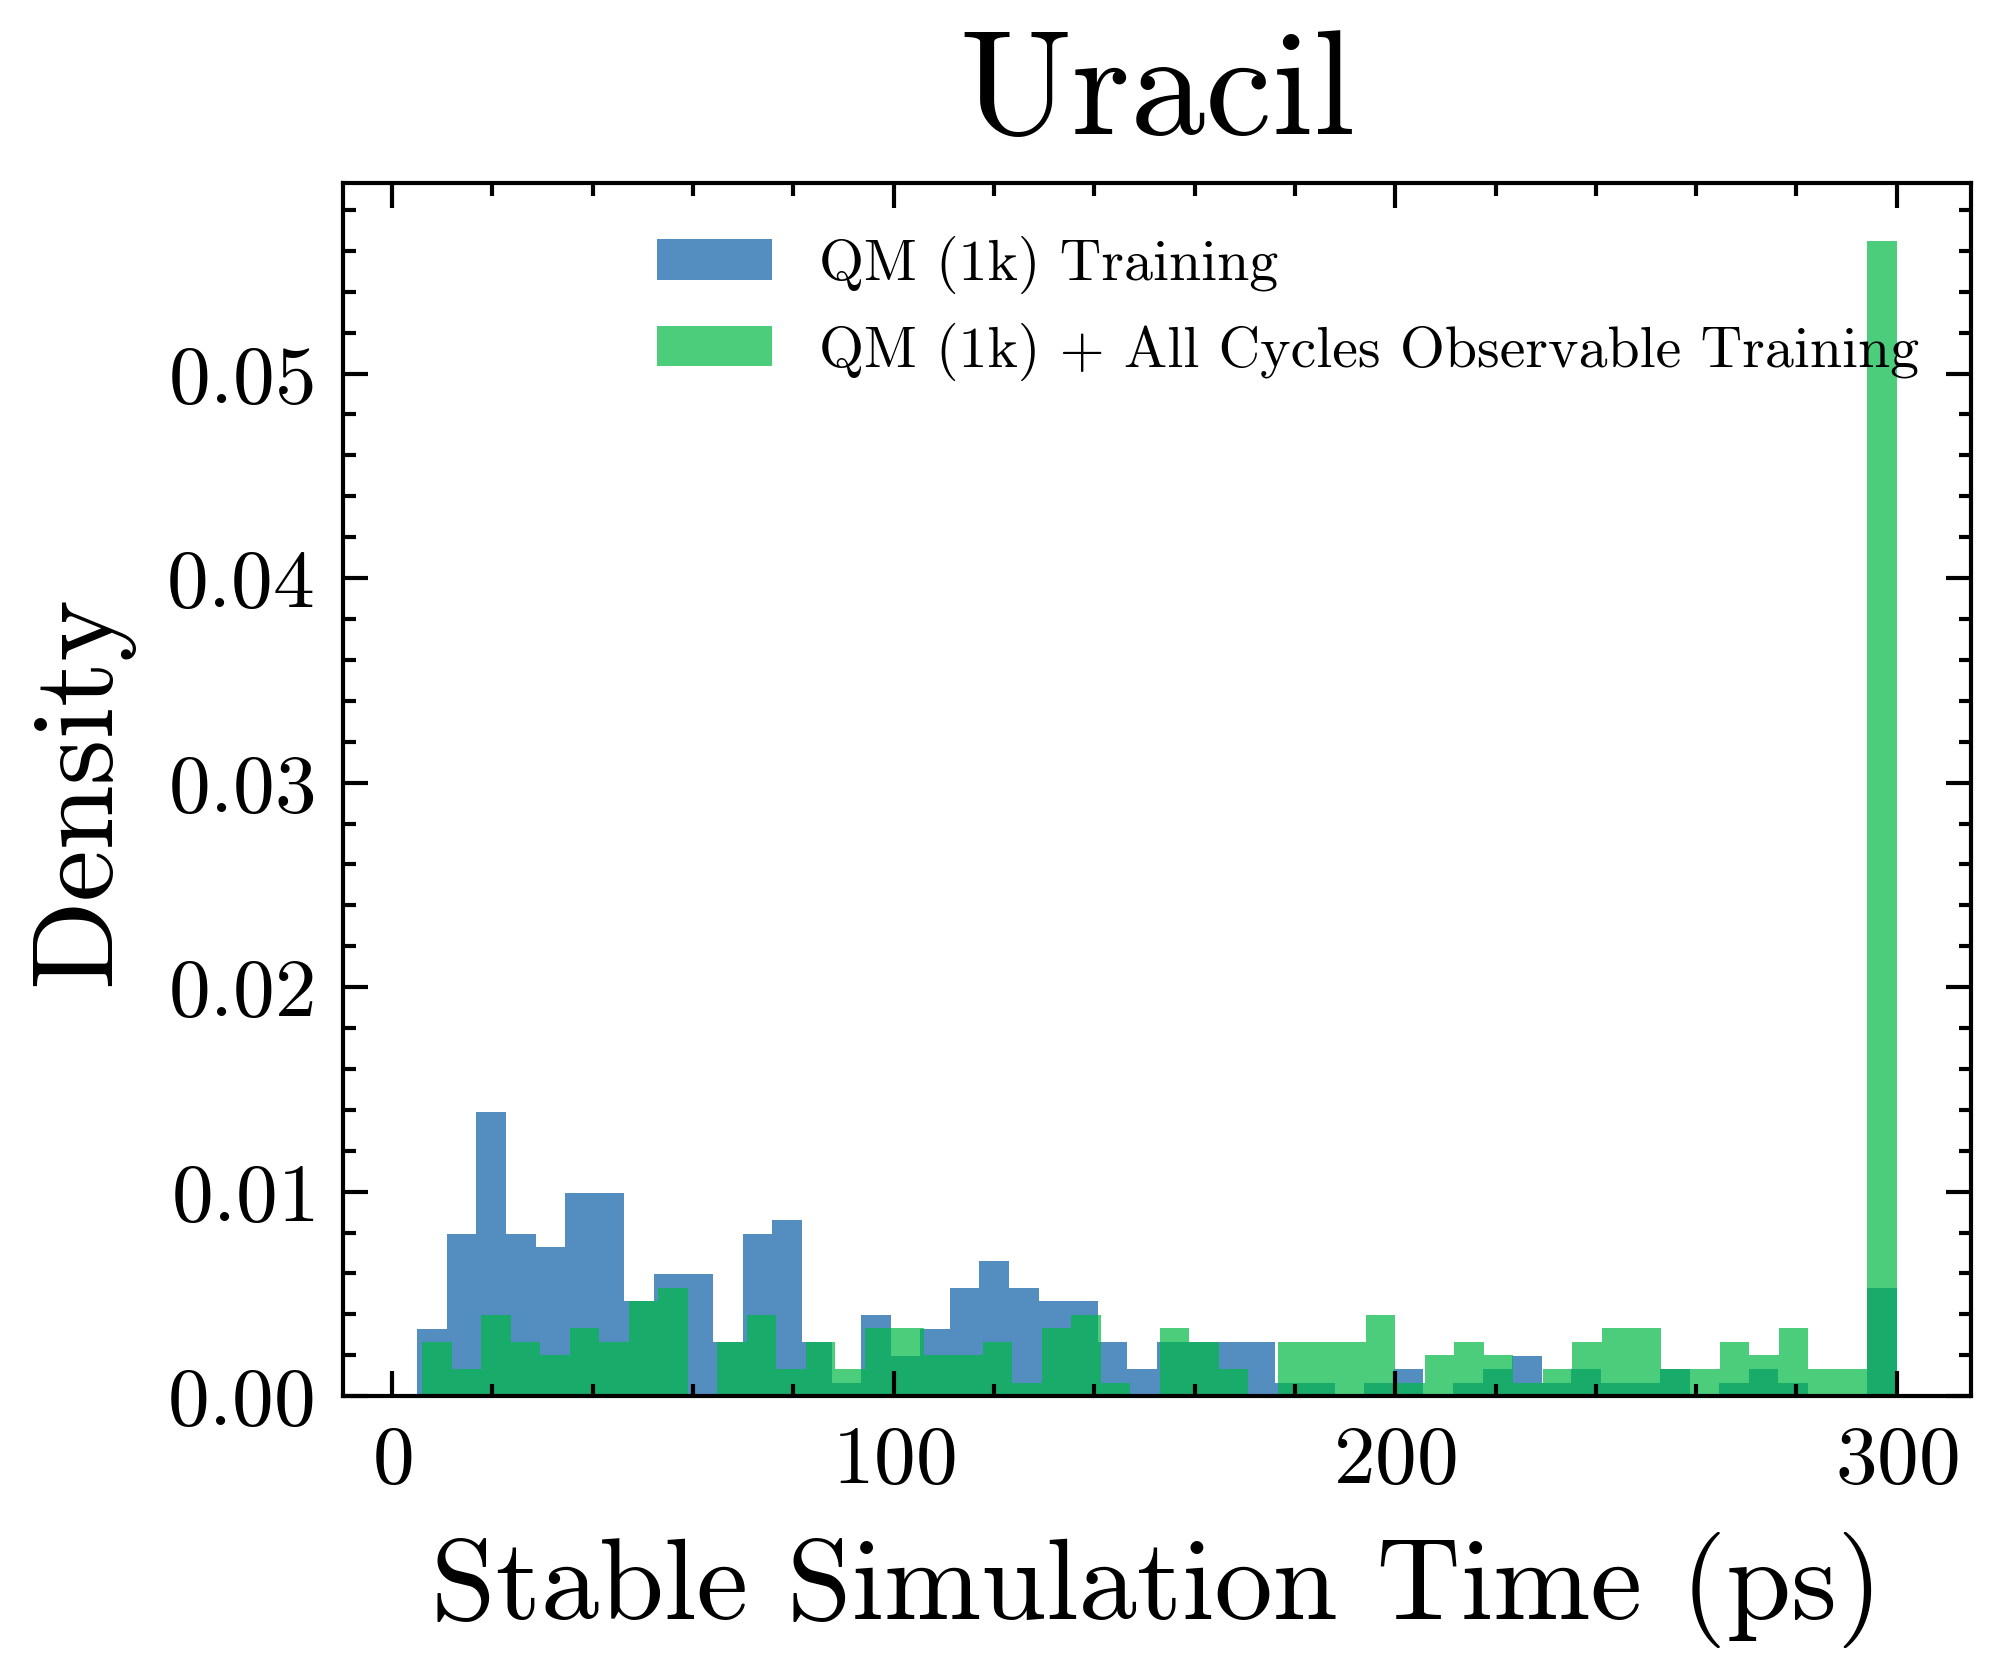

In [71]:

molecule = 'uracil'
exp_dir = f'/global/cfs/projectdirs/m4319/sanjeevr/results_md17_correctedlogging/IMPLICIT_schnet_{molecule}_TEST_correctedlogging_lr=0.001_efweight=10'
gt_dir = f'/data/sanjeevr/contiguous-md17/{molecule}/10k/val/nequip_npz.npz'
names = ['pre', 'post']
#collect_metrics(molecule, exp_dir, names)
plot_stability_distribution(molecule, exp_dir, names)
#plot_observable_mae_distribution(molecule, exp_dir, names, 'vacf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'adf')
# plot_observable_mae_distribution(molecule, exp_dir, names, 'vacf')
#plot_observable_mae_difference_distribution(molecule, exp_dir, names, 'vacf')
#plot_observable(molecule, exp_dir, names, 'vacf', diff=False)

